In [1]:
import numpy as np
from functools import partial
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

import elfi
import outbreak4elfi

## Using ABC/BOLFI to infer the basic reproduction number R0 for the Ebola virus

Using data from supplement 2 in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4235004/

In [2]:
# data = pd.read_excel('NIHMS60898-supplement-Supplement2.xlsx', sheet_name=1)

The data selected here: median cumulative count for confirmed, probable and suspected cases, derived using the renewal method using a serial interval 15.3 days and the line list database. 

Country: Guinea

In [3]:
data = np.array([[487, 515, 555, 612, 694, 810, 976, 1215, 1555, 2042, 2738, 3727, 5153, 7202, 10122, 14272, 20213, 28752]])

Setup external simulator and summary statistic

In [4]:
def simulator(R0, batch_size=1, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState()
    output = outbreak4elfi.simulateR0(R0, batch_size, random_state.get_state()[1][0])
    return output

Define appropriate summary statistic

In [5]:
# ratio of consequtive values
def _conseq_ratio1d(x, lag):  # single row
    inds = np.where(x > 0, np.arange(len(x)), np.nan)
    ind1 = max(int(np.nanmin(inds)) + 2, 3)  # first non-null + skip some initial
    ind2 = int(np.nanmax(inds)) + 1  # last non-null +1
    view1 = x[ind1:ind2-lag]
    view2 = x[ind1+lag:ind2]
    ratio = np.mean(view2 / view1)
    return ratio
    
def conseq_ratio(x, lag=1):
    cr1d = partial(_conseq_ratio1d, lag=lag)
    return np.apply_along_axis(cr1d, axis=1, arr=x)

Setup ELFI

In [6]:
m = elfi.new_model()
R0 = elfi.Prior('truncnorm', -1.3, 4.6, 1.7, 0.5)  # [1.05, 4]
sim = elfi.Simulator(simulator, R0, observed=data)
s1 = elfi.Summary(conseq_ratio, sim, 2)
d = elfi.Distance('euclidean', s1)
log_d = elfi.Operation(np.log, d)

Setup BOLFI and fit the GP

In [7]:
%%time
bolfi = elfi.BOLFI(log_d, bounds={'R0': [1.05, 4]}, acq_noise_var=0.1)
bolfi.fit(100)

CPU times: user 56.3 s, sys: 50 ms, total: 56.3 s
Wall time: 45.9 s


 /usr/lib/python3/dist-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


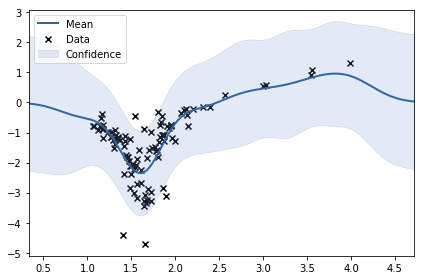

In [8]:
bolfi.target_model._gp.plot()

Sample the posterior using MCMC

In [9]:
res = bolfi.sample(1000)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
R0 1697.51469331 1.00000211552


In [10]:
res

Method: BOLFI
Number of samples: 2000
Number of simulations: 100
Threshold: -2.35
Sample means: R0: 1.6

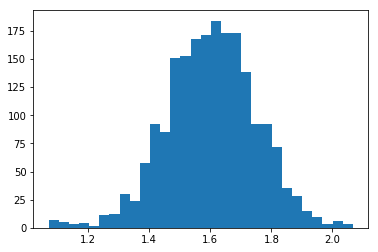

In [11]:
plt.hist(res.samples['R0'], bins=30);